# Load Data

In [1]:
from utils import *

In [2]:
patients = data_preprocessing('AE_Visit_example5k.csv')
patients

,Pathway,FirstTimetoED,1,Time1,2,Time2,3,Time3,4,Time4,5,Time5,6,Time6,7,Time7,8,Time8,isAdmitted
1,0.0,14.166667,1,305.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2,1.0,20.183333,2,158.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1
8,1.0,7.533333,3,31.0,4,481.0,5,78.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
10,0.0,21.000000,6,51.0,2,186.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1
15,1.0,10.816667,8,3.0,7,187.0,2,172.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,15.600000,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4994,0.0,14.950000,5,170.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1
4996,0.0,15.583333,3,62.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4998,1.0,15.066667,3,11.0,2,205.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [3]:
region_sequences = patients.iloc[:, 2:-1:2].values
time_sequences = patients.iloc[:, 3::2].values
label = patients['isAdmitted'].values
other_features = patients.iloc[:, :2].values

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# LSTM + XGBM

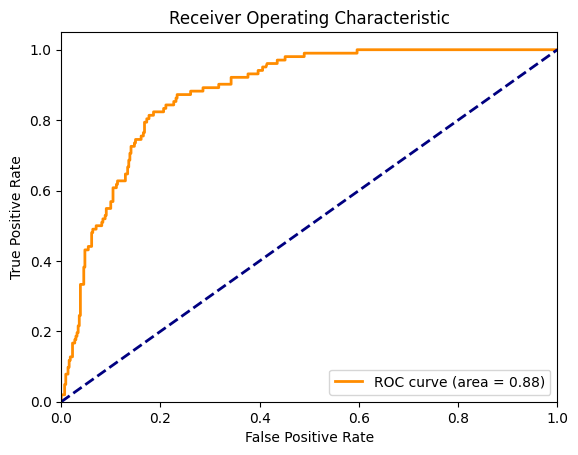

In [5]:
from lstm_model import LSTM
from xgboost import XGBClassifier
from my_model import MyModel
params = {'hidden_size': 64, 'lr': 0.001, 'num_epochs': 20, 'region_embedding_dim': 16,
          'time_embedding_dim': 32}
myLSTM = LSTM(vocab_size=15, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=1).to(device)

xgb_params = {
    'n_estimators': 400,
    'learning_rate': 0.01,
    'tree_method': "hist",
}
xgb_classifier = XGBClassifier(**xgb_params)

my_model = MyModel(myLSTM, xgb_classifier, region_sequences,
                   time_sequences, other_features, label, params, device)
lstm, xgb = my_model.train()
predict_proba, labels_test = my_model.evaluate(lstm, xgb)
draw_roc_curve(predict_proba, labels_test)
my_model.save_model(lstm, xgb, 'lstm', 'xgb')

# LSTM + LightGBM

[LightGBM] [Info] Number of positive: 411, number of negative: 1757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16575
[LightGBM] [Info] Number of data points in the train set: 2168, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189576 -> initscore=-1.452770
[LightGBM] [Info] Start training from score -1.452770


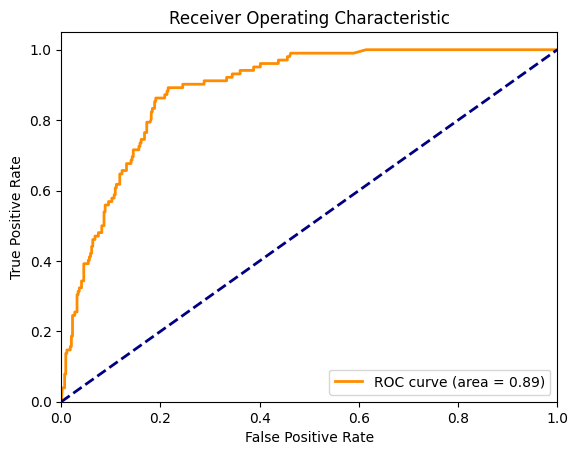

In [6]:
import lightgbm as lgb
from lstm_model import LSTM
from my_model import MyModel
params = {'hidden_size': 64, 'lr': 0.1, 'num_epochs': 10, 'region_embedding_dim': 16,
          'time_embedding_dim': 16}
lgb_params = {
    'objective': 'binary', #定义的目标函数
    'learning_rate': 0.03,
}
lgb_classifier = lgb.LGBMClassifier(**lgb_params)
myLSTM = LSTM(vocab_size=15, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=1).to(device)
my_model = MyModel(myLSTM, lgb_classifier, region_sequences,
                   time_sequences, other_features, label, params, device)
lstm, lgbm = my_model.train()
predict_proba, labels_test = my_model.evaluate(lstm, lgbm)
draw_roc_curve(predict_proba, labels_test)

# LSTM + Random Forest

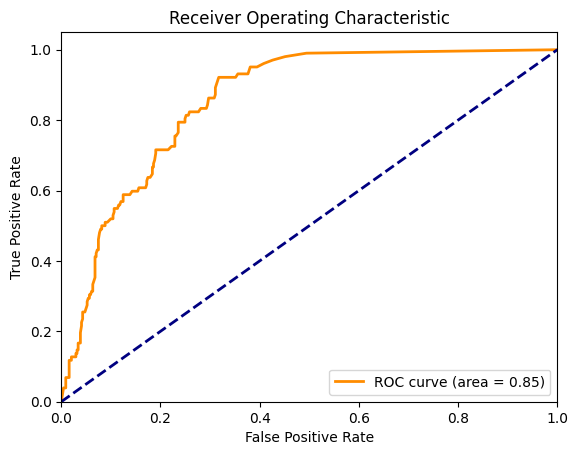

In [7]:
from sklearn.ensemble import RandomForestClassifier

params = {'hidden_size': 16, 'lr': 0.1, 'num_epochs': 10, 'region_embedding_dim': 16,
          'time_embedding_dim': 16}

rf_classifier = RandomForestClassifier(n_estimators=300)
myLSTM = LSTM(vocab_size=15, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=1).to(device)
my_model = MyModel(myLSTM, rf_classifier, region_sequences,
                   time_sequences, other_features, label, params, device)
lstm, rf = my_model.train()
predict_proba, labels_test = my_model.evaluate(lstm, rf)
draw_roc_curve(predict_proba, labels_test)

In [10]:
from sklearn.model_selection import train_test_split

X = patients.iloc[:, :-1].values
y = patients['isAdmitted'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Only LightGBM

In [8]:
import lightgbm as lgb
lgb_params = {
    'objective': 'binary', #定义的目标函数
    'learning_rate': 0.03,
}

[LightGBM] [Info] Number of positive: 413, number of negative: 1755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 2168, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190498 -> initscore=-1.446777
[LightGBM] [Info] Start training from score -1.446777


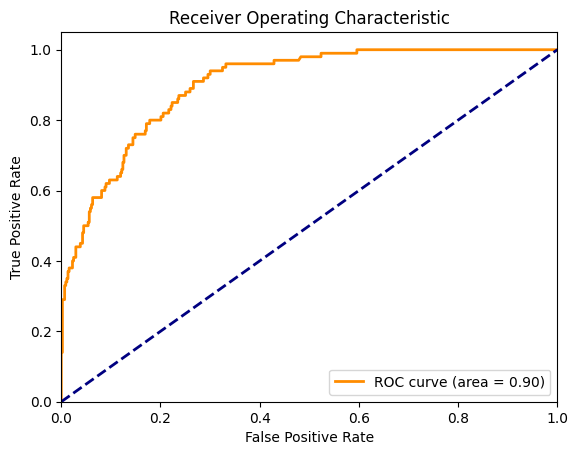

In [11]:
lgb_classifier = lgb.LGBMClassifier(**lgb_params)
lgb_classifier.fit(X_train, y_train)
predict_proba = lgb_classifier.predict_proba(X_test)[:, 1]
draw_roc_curve(predict_proba, y_test)

# Only XGBM

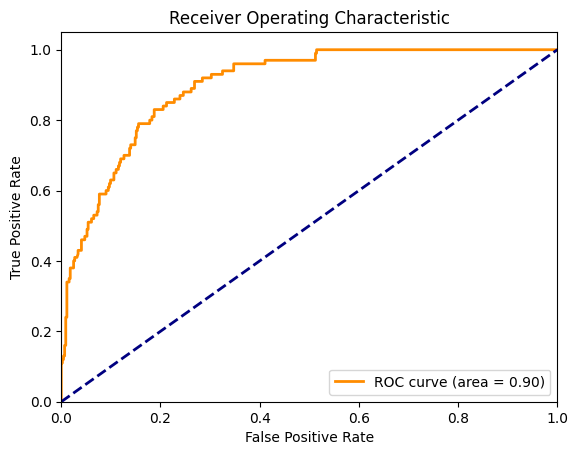

In [12]:
from xgboost import XGBClassifier
xgb_params = {
    'n_estimators': 400,
    'learning_rate': 0.01,
    'tree_method': "hist",
}

xgb_classifier = XGBClassifier(**xgb_params)
xgb_classifier.fit(X_train, y_train)
predict_proba = xgb_classifier.predict_proba(X_test)[:, 1]
draw_roc_curve(predict_proba, y_test)

# Only Random Forest

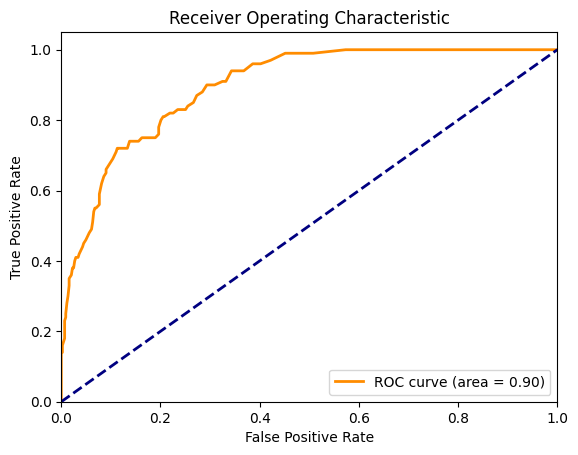

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predict_proba = rf.predict_proba(X_test)[:, 1]
draw_roc_curve(predict_proba, y_test)